In [1]:
import urllib
from IPython.display import Markdown as md

### change to reflect your notebook
_nb_loc = "11_adv_problems/10g_scann_search.ipynb"
_nb_title = "Searching for embeddings"
_icons=["https://raw.githubusercontent.com/GoogleCloudPlatform/practical-ml-vision-book/master/logo-cloud.png", "https://www.tensorflow.org/images/colab_logo_32px.png", "https://www.tensorflow.org/images/GitHub-Mark-32px.png", "https://www.tensorflow.org/images/download_logo_32px.png"]
_links=["https://console.cloud.google.com/vertex-ai/workbench/deploy-notebook?" + urllib.parse.urlencode({"name": _nb_title, "download_url": "https://github.com/takumiohym/practical-ml-vision-book-ja/raw/master/"+_nb_loc}), "https://colab.research.google.com/github/takumiohym/practical-ml-vision-book-ja/blob/master/{0}".format(_nb_loc), "https://github.com/takumiohym/practical-ml-vision-book-ja/blob/master/{0}".format(_nb_loc), "https://raw.githubusercontent.com/takumiohym/practical-ml-vision-book-ja/master/{0}".format(_nb_loc)]
md("""<table class="tfo-notebook-buttons" align="left"><td><a target="_blank" href="{0}"><img src="{4}"/>Run in Vertex AI Workbench</a></td><td><a target="_blank" href="{1}"><img src="{5}" />Run in Google Colab</a></td><td><a target="_blank" href="{2}"><img src="{6}" />View source on GitHub</a></td><td><a href="{3}"><img src="{7}" />Download notebook</a></td></table><br/><br/>""".format(_links[0], _links[1], _links[2], _links[3], _icons[0], _icons[1], _icons[2], _icons[3]))

<table class="tfo-notebook-buttons" align="left"><td><a target="_blank" href="https://console.cloud.google.com/vertex-ai/workbench/deploy-notebook?name=Searching+for+embeddings&download_url=https%3A%2F%2Fgithub.com%2Ftakumiohym%2Fpractical-ml-vision-book-ja%2Fraw%2Fmaster%2F11_adv_problems%2F10g_scann_search.ipynb"><img src="https://raw.githubusercontent.com/GoogleCloudPlatform/practical-ml-vision-book/master/logo-cloud.png"/>Run in Vertex AI Workbench</a></td><td><a target="_blank" href="https://colab.research.google.com/github/takumiohym/practical-ml-vision-book-ja/blob/master/11_adv_problems/10g_scann_search.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a></td><td><a target="_blank" href="https://github.com/takumiohym/practical-ml-vision-book-ja/blob/master/11_adv_problems/10g_scann_search.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a></td><td><a href="https://raw.githubusercontent.com/takumiohym/practical-ml-vision-book-ja/master/11_adv_problems/10g_scann_search.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a></td></table><br/><br/>

# 埋め込みの検索  
このノートブックは、埋め込みとSCaNNを使用して高速画像検索を実装する方法を示しています。

## GPUの有効化

Colab:
- [Edit]→[Notebook Setting]へ移動
- [Hardware Accelerator]ドロップダウンから[TPU]を選択

Vertex AI Workbench:
- https://console.cloud.google.com/vertex-ai/workbench/list/instances に移動
- [New Notebook] -> [TensorFlow Enterprise] -> [TensorFlow Enterprise 2.8] -> [With 1 NVIDIA Tesla T4] -> [Install NVIDIA GPU driver automatically for me]にチェック -> [Create] でインスタンスを作成



In [2]:
%pip install --quiet --user scann tensorflow-addons

Note: you may need to restart the kernel to use updated packages.


In [3]:
import scann
import tensorflow as tf
import tensorflow_addons as tfa

print(tf.version.VERSION)
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    pass
    # raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

2.9.1
Found GPU at: /device:GPU:0


2022-07-31 17:10:02.245647: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-31 17:10:02.873115: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-31 17:10:02.884398: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-31 17:10:02.885141: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

## 埋め込みのインデックスを作成する  

事前にトレーニングされたMobileNetモデルを使用して、Flowerデータセット内の100枚の画像の埋め込みを作成します  


In [4]:
import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_addons as tfa
import scann
import os

os.environ['TFHUB_MODEL_LOAD_FORMAT'] = 'UNCOMPRESSED'

IMG_HEIGHT = 224
IMG_WIDTH = 224
IMG_CHANNELS = 3
BATCH_SIZE = 32
NUM_IMAGES = 100
NUM_NEIGH = 3 # top 3
CLASS_NAMES = ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


def read_and_decode(filename, reshape_dims=[IMG_HEIGHT, IMG_WIDTH]):
  # Read the file
  img = tf.io.read_file(filename)
  # Convert the compressed string to a 3D uint8 tensor.
  img = tf.image.decode_jpeg(img, channels=IMG_CHANNELS)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # Resize the image to the desired size.
  return tf.image.resize(img, reshape_dims)

def decode_csv(csv_row):
  record_defaults = ["path", "flower"]
  filename, label_string = tf.io.decode_csv(csv_row, record_defaults)
  img = read_and_decode(filename, [IMG_WIDTH, IMG_HEIGHT])
  label = tf.argmax(tf.math.equal(CLASS_NAMES, label_string))
  return filename, img, label, label_string

In [5]:
layers = [
      hub.KerasLayer(
          "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4",
          input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS),
          trainable=False,
          name='mobilenet_embedding'),
      tf.keras.layers.Flatten()
]
model = tf.keras.Sequential(layers, name='flowers_embedding')
print(model.summary())

2022-07-31 17:10:04.105383: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-31 17:10:04.106176: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-31 17:10:04.106777: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-31 17:10:04.107705: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-31 17:10:04.108319: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from S

Model: "flowers_embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_embedding (KerasL  (None, 1280)             2257984   
 ayer)                                                           
                                                                 
 flatten (Flatten)           (None, 1280)              0         
                                                                 
Total params: 2,257,984
Trainable params: 0
Non-trainable params: 2,257,984
_________________________________________________________________
None


In [6]:
def create_embeddings_dataset(embedder, csvfilename, num_images, shuffle=False):
  ds = tf.data.TextLineDataset(csvfilename).map(decode_csv)
  if shuffle:
    ds = ds.shuffle(10000)
  ds = ds.take(num_images).batch(BATCH_SIZE)
  dataset_filenames = []
  dataset_embeddings = []
  for filenames, images, _, _ in ds:
    embeddings = embedder(images)
    dataset_filenames.extend([f.numpy().decode('utf-8') for f in filenames])
    dataset_embeddings.extend(embeddings)
  dataset_embeddings = tf.convert_to_tensor(dataset_embeddings)
  return dataset_filenames, dataset_embeddings

In [7]:
dataset_filenames, dataset_embeddings = create_embeddings_dataset(
    lambda x: model.predict(x),
    "gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/train_set.csv", NUM_IMAGES
)
print(dataset_filenames[:3])
print(dataset_embeddings.shape) # should be (NUM_IMAGES, 1280)

query_filenames, query_embeddings = create_embeddings_dataset(
    lambda x: model.predict(x),
    "gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/eval_set.csv", 2
)
print(query_embeddings.shape)

2022-07-31 17:10:08.259920: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8200


1/1 [==============================] - 1s 646ms/step
['gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/daisy/754296579_30a9ae018c_n.jpg', 'gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/dandelion/18089878729_907ed2c7cd_m.jpg', 'gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/dandelion/284497199_93a01f48f6.jpg']
(100, 1280)
1/1 [==============================] - 0s 236ms/step
(2, 1280)


In [8]:
## Create SCaNN searcher
searcher = scann.scann_ops.builder(dataset_embeddings, NUM_NEIGH, "dot_product").score_ah(2).build()

[libprotobuf WARNING external/com_google_protobuf/src/google/protobuf/text_format.cc:339] Warning parsing text-format research_scann.ScannConfig: 25:11: text format contains deprecated field "min_cluster_size"
2022-07-31 17:10:12.469559: I scann/base/single_machine_factory_scann.cc:112] Single-machine AH training with dataset size = 100, 4 thread(s).


In [9]:
neighbors, distances = searcher.search_batched(query_embeddings)
print(neighbors)
print(distances)

tf.Tensor(
[[36 42 11]
 [95 26 27]], shape=(2, 3), dtype=int32)
tf.Tensor(
[[390.55447 379.76324 356.11118]
 [457.37067 362.77005 336.50104]], shape=(2, 3), dtype=float32)


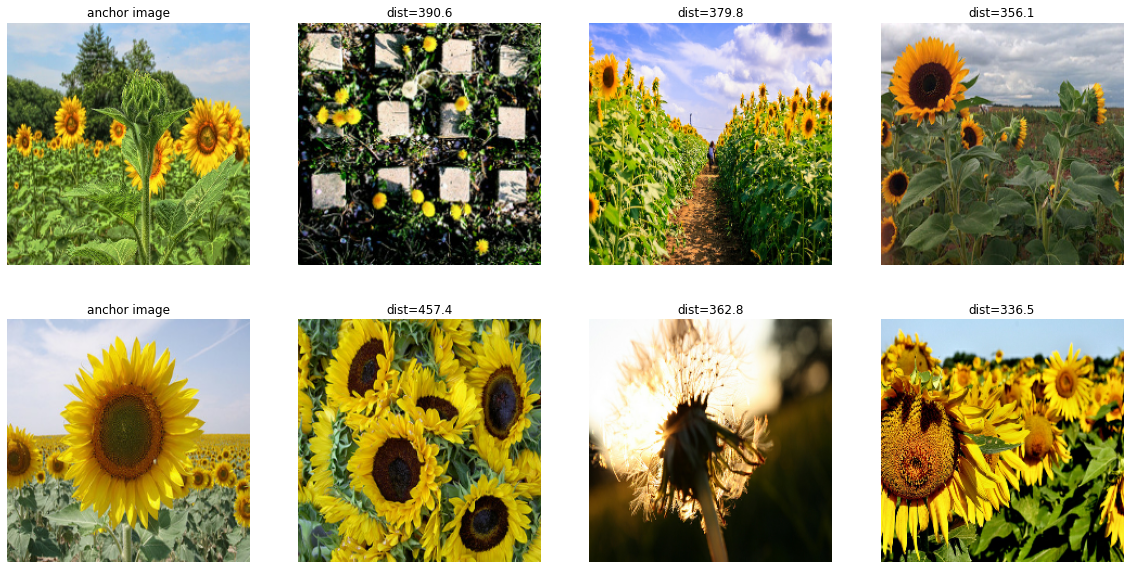

In [10]:
def plot_neighbors(query_filenames, neighbors, distances):
    f, ax = plt.subplots(len(query_filenames), NUM_NEIGH + 1,
                         figsize=(5 * (1 + NUM_NEIGH), 5 * len(query_filenames)))
    for rowno, query_filename in enumerate(query_filenames):
      ax[rowno][0].imshow(read_and_decode(query_filename).numpy())
      ax[rowno][0].set_title('anchor image')
      ax[rowno][0].axis('off')
      for colno, neigh in enumerate(neighbors[rowno]):
        ax[rowno][colno+1].imshow(read_and_decode(dataset_filenames[neigh]).numpy())
        ax[rowno][colno+1].set_title('dist={:.1f}'.format(distances[rowno][colno].numpy()))
        ax[rowno][colno+1].axis('off')

plot_neighbors(query_filenames, neighbors, distances)

## トリプレットロス  

ここでは、分類用のデータセットを使用して埋め込みをトレーニングします。  
しかしゴールは分類問題自体ではなくより良い埋め込みを作成することなので、トリプレット損失を使用し、特にセミハード損失を最小化するように設計します。

参照:  
* https://arxiv.org/pdf/1503.03832.pdf  
* https://www.tensorflow.org/addons/tutorials/losses_triplet  
* https://omoindrot.github.io/triplet-loss  

注意:  
トリプレット損失は、それぞれのバッチの正のペアがない場合、最終的にNaNになるように定義されています。
そのため、バッチサイズはこれが発生しないように十分に大きくする必要があります。

In [11]:
layers = [
    hub.KerasLayer(
          "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4",
          input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS),
          trainable=False,
          name='mobilenet_embedding'),
    tf.keras.layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1), name='normalize_embeddings')
]

model = tf.keras.Sequential(layers, name='flowers_embedding')

model.compile(optimizer=tf.keras.optimizers.Adam(0.001), loss=tfa.losses.TripletSemiHardLoss())
print(model.summary())

Model: "flowers_embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_embedding (KerasL  (None, 1280)             2257984   
 ayer)                                                           
                                                                 
 normalize_embeddings (Lambd  (None, 1280)             0         
 a)                                                              
                                                                 
Total params: 2,257,984
Trainable params: 0
Non-trainable params: 2,257,984
_________________________________________________________________
None


In [12]:
train_dataset = (tf.data.TextLineDataset(
    "gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/train_set.csv").
    map(decode_csv)).map(lambda path, img, lint, ls: (img, lint)).batch(BATCH_SIZE)

history = model.fit(train_dataset.cache(), epochs=1)

104/104 [==============================] - 61s 547ms/step - loss: 0.9703


In [13]:
# repeat with new model
dataset_filenames, dataset_embeddings = create_embeddings_dataset(
    lambda x: model.predict(x),
    "gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/train_set.csv", NUM_IMAGES
)

query_filenames, query_embeddings = create_embeddings_dataset(
    lambda x: model.predict(x),
    "gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/eval_set.csv", 2
)

1/1 [==============================] - 0s 23ms/step


In [14]:
searcher = scann.scann_ops.builder(dataset_embeddings, NUM_NEIGH, "dot_product").score_ah(2).build()
neighbors, distances = searcher.search_batched(query_embeddings)

[libprotobuf WARNING external/com_google_protobuf/src/google/protobuf/text_format.cc:339] Warning parsing text-format research_scann.ScannConfig: 25:11: text format contains deprecated field "min_cluster_size"
2022-07-31 17:11:20.376494: I scann/base/single_machine_factory_scann.cc:112] Single-machine AH training with dataset size = 100, 4 thread(s).


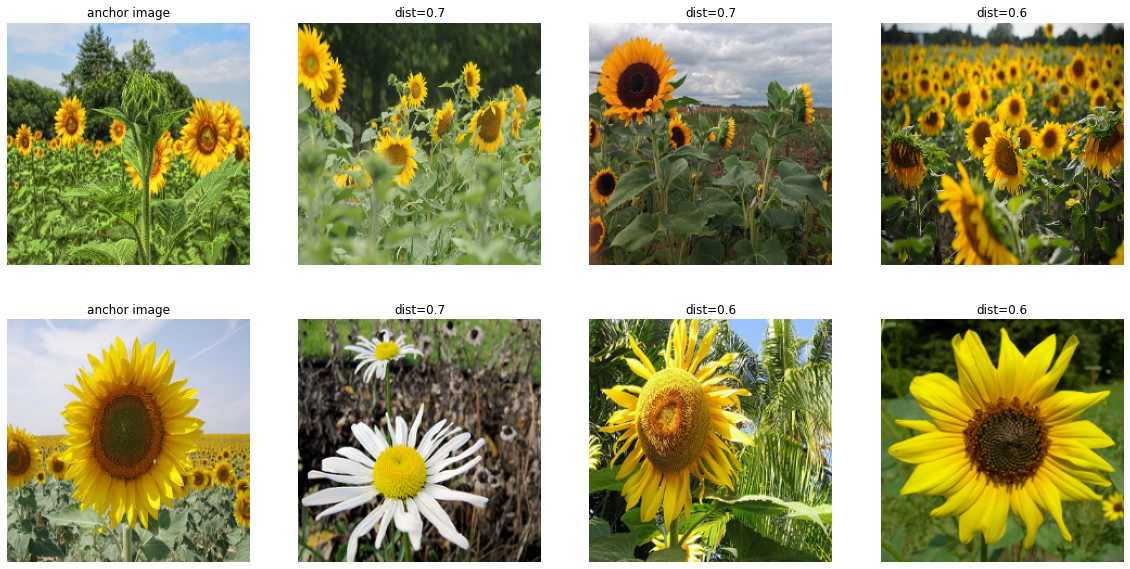

In [15]:
plot_neighbors(query_filenames, neighbors, distances)

## プロジェクターで埋め込みを表示する  

TensorFlow Embedding Projectorで表示するファイルを作成します

In [16]:
import io
import tensorflow_datasets as tfds

test_dataset = (tf.data.TextLineDataset(
    "gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/eval_set.csv").
    map(decode_csv)).map(lambda path, img, lint, ls: (img,lint)).take(NUM_IMAGES).batch(NUM_IMAGES)

test_results = model.predict(test_dataset.map(lambda img, lint: img))

np.savetxt("vecs.tsv", test_results, delimiter='\t')

out_m = io.open('meta.tsv', 'w', encoding='utf-8')
for img, labels in tfds.as_numpy(test_dataset):
    [out_m.write(CLASS_NAMES[x] + "\n") for x in labels]
out_m.close()

1/1 [==============================] - 3s 3s/step


以下の手順で埋め込みを確認してください。
- https://projector.tensorflow.org/ へアクセス
- 左側ウィンドウの `Load` をクリックし、`vecs.tsv` と`meta.tsv`をそれぞれアップロード
- 表示された埋め込みの中からひとつの点をダブルクリックすると、以下の画像のように右ウィンドウに近傍ベクトルが順々に表示

また、画面左下から、可視化のために低次元へ次元縮約するアルゴリズムの選択ができます（PCA, T-SNEなど）。

<img width="600" src="embedding_projection.png"/>

## 可視化による確認
もちろん、埋め込みモデルは、ラベルだけに基づいて埋め込みを行うわけではなく、畳み込み層は画像中のさまざまな特徴から埋め込みを抽出しています。<br>

以下を何度か実行し、実際の画像検索のサンプルをいくつか可視化してみましょう。

1/1 [==============================] - 0s 367ms/step


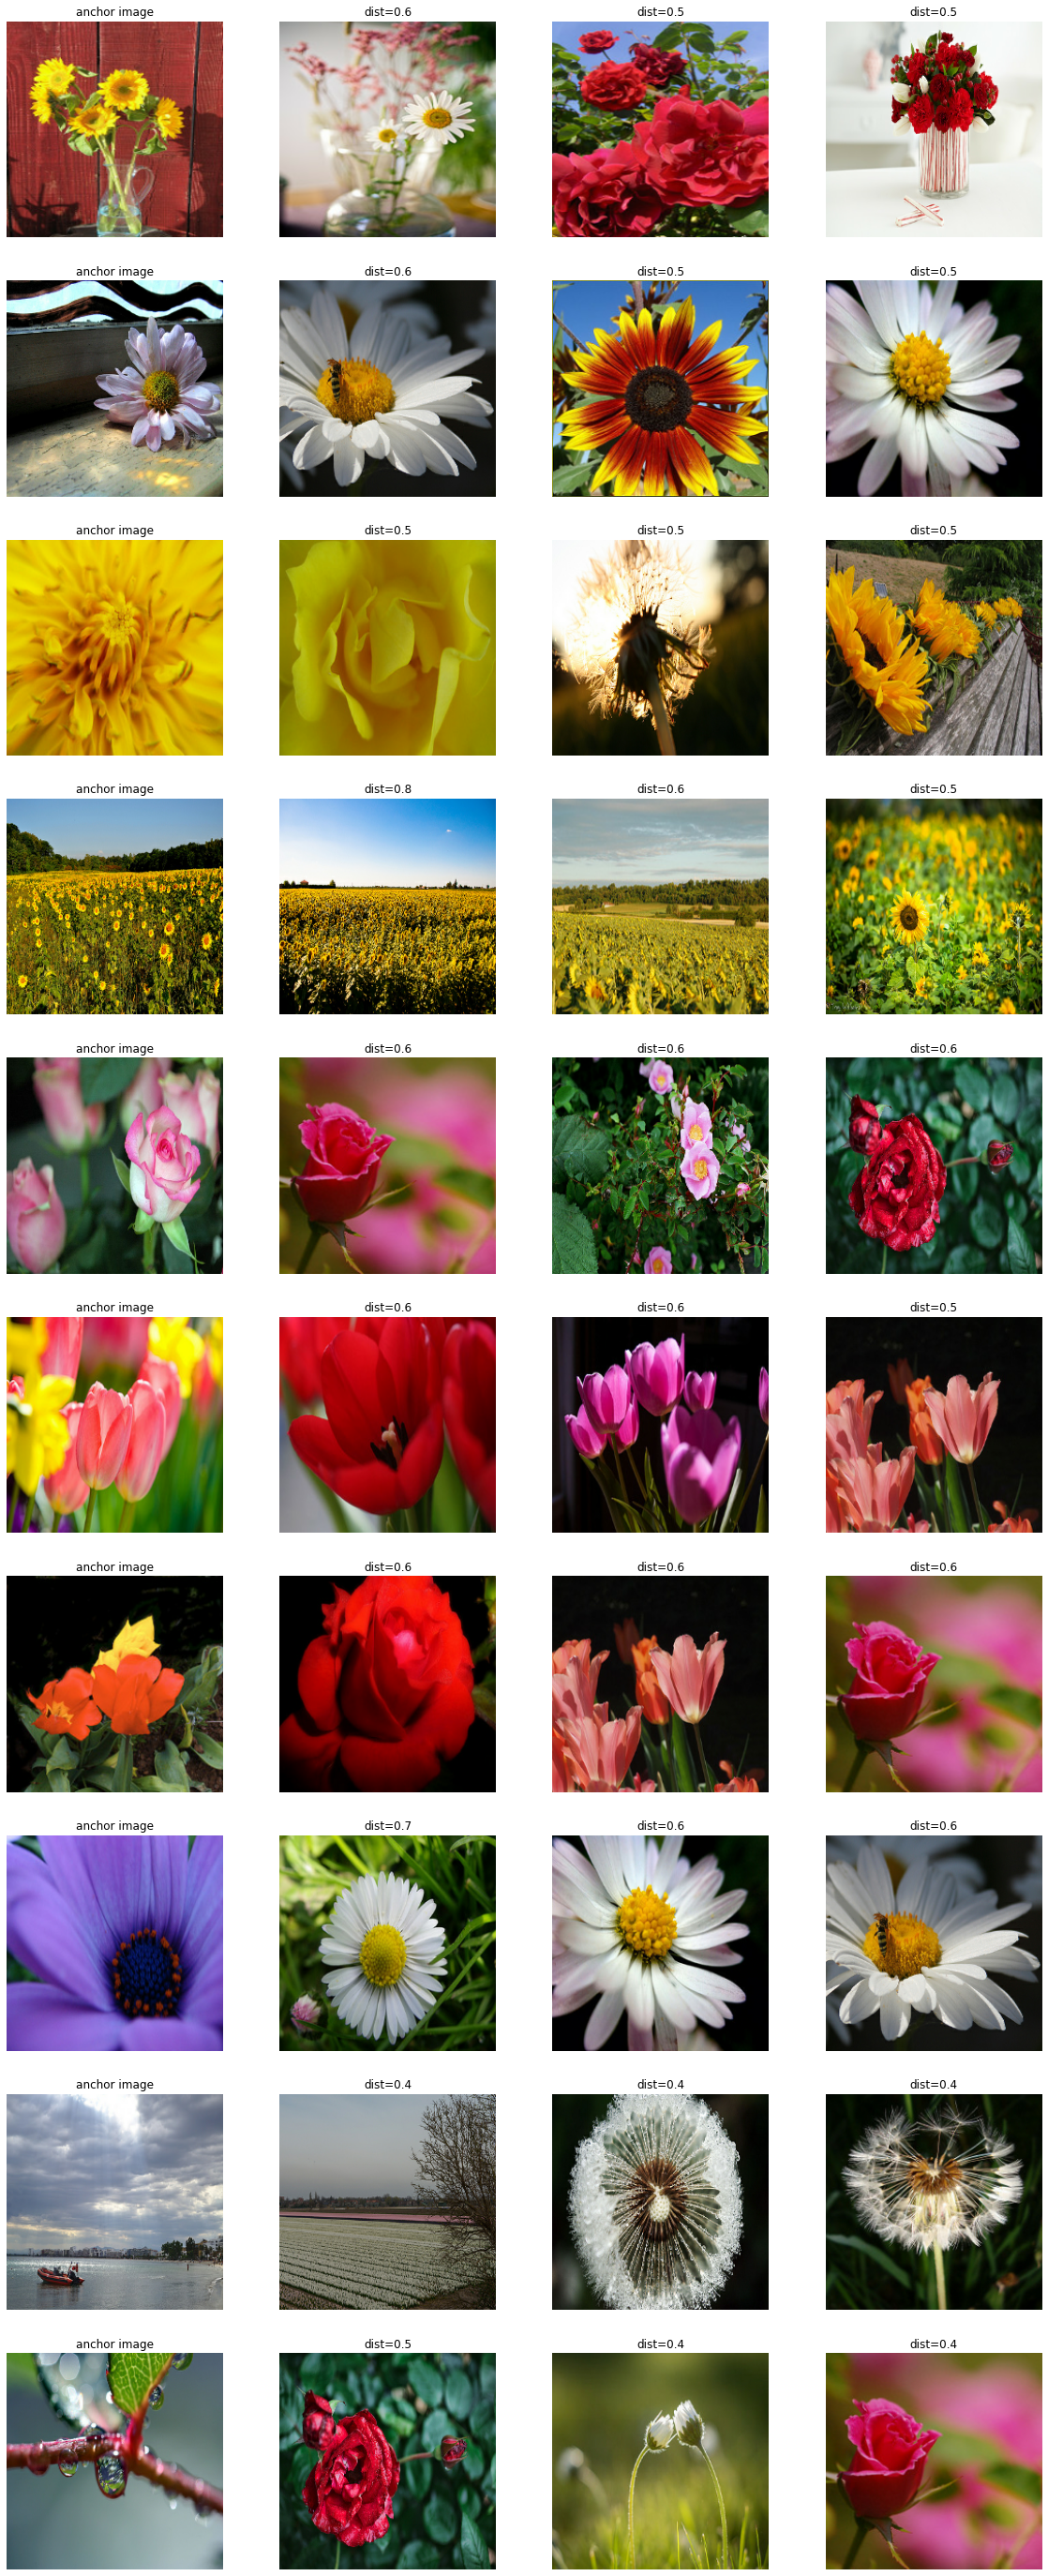

In [17]:
query_filenames, query_embeddings = create_embeddings_dataset(
    lambda x: model.predict(x),
    "gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/eval_set.csv", 10, True
)
neighbors, distances = searcher.search_batched(query_embeddings)

plot_neighbors(query_filenames, neighbors, distances)

## License
Copyright 2022 Google Inc. Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0 Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.